In [2]:
import time
import torch
import pickle
import numpy as np
import pandas as pd
import torch.nn as nn

class LinearReLU(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearReLU, self).__init__()
        self.fc = nn.Linear(in_features, out_features)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.0)
    
    def forward(self, x):
        return self.dropout(self.relu(self.fc(x)))

class MLP(nn.Module):
    def __init__(self, n_class=10, n_layer=1):
        super(MLP, self).__init__()
        self.fc1 = LinearReLU(784, 256)
        self.fc2_layers = nn.ModuleList([LinearReLU(256, 256) for _ in range(n_layer)])
        self.fc3 = nn.Linear(256, n_class)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        
        # fc2_layers를 반복적으로 적용
        for layer in self.fc2_layers:
            x = layer(x)
            
        x = self.fc3(x)
        return x

def prune_gradients(model):
    parameters = model.parameters()
    if isinstance(parameters, torch.Tensor):
        parameters = [parameters]
        parameters = list(
            filter(lambda p: p.grad is not None, parameters))
    input_grads = [p.grad.data for p in parameters]
    threshold = [torch.quantile(torch.abs(input_grads[i]), 0.9) for i in range(len(input_grads))]
    for i, p in enumerate(model.parameters()):
        p.grad[torch.abs(p.grad) < threshold[i]] = 0

def sanitize(tensor):
    eps = 8
    delta = 0.1
    
    sigma = np.sqrt(2 * np.log(1.25 / delta)) / eps
    clip_norm = 1.5
    
    tensor_norm = torch.norm(tensor, p=2)
    if tensor_norm > clip_norm:
        tensor = tensor * (clip_norm / tensor_norm)
    noise = torch.normal(mean=0, std=sigma * clip_norm, size=tensor.shape).to(tensor.device)
    tensor = tensor + noise
    return tensor

def sanitize_gradients(model):
    for p in model.parameters():
        if p.grad is not None:
            sanitized_grad = sanitize(p.grad.data)
            p.grad.data = sanitized_grad

def nodefense(model, iteration=100, batch_size=32, num_batch=100):
    x = torch.randn(batch_size, 1, 28, 28)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    model.train()
    model.to('cpu')
    elapsed_times = []
    peak_mem_usages = []
    for _ in range(iteration):
        start = time.process_time()
        # start = time.time())
        for _ in range(num_batch):
            o = model(x)
            y = torch.LongTensor(torch.randint(0,9,(batch_size,)))
            loss = criterion(o, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        end = time.process_time()
        # end = time.time()
        elapsed_times.append(end-start)
    return elapsed_times, peak_mem_usages

def dp(model, iteration=100, batch_size=32, num_batch=100):
    x = torch.randn(batch_size, 1, 28, 28)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    model.train()
    model.to('cpu')
    elapsed_times = []
    peak_mem_usages = []
    for _ in range(iteration):
        start = time.process_time()
        # start = time.time()
        for _ in range(num_batch):
            o = model(x)
            y = torch.LongTensor(torch.randint(0,9,(batch_size,)))
            loss = criterion(o, y)
            optimizer.zero_grad()
            loss.backward()
            sanitize_gradients(model)
            optimizer.step()
        end = time.process_time()
        # end = time.time()
        elapsed_times.append(end-start)
    return elapsed_times, peak_mem_usages  

def gp(model, iteration=100, batch_size=32, num_batch=100):
    x = torch.randn(batch_size, 1, 28, 28)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    model.train()
    model.to('cpu')
    elapsed_times = []
    peak_mem_usages = []
    for _ in range(iteration):
        start = time.process_time()
        # start = time.time()
        # tracemalloc.start()
        for _ in range(num_batch):
            o = model(x)
            y = torch.LongTensor(torch.randint(0,9,(batch_size,)))
            loss = criterion(o, y)
            optimizer.zero_grad()
            loss.backward()
            prune_gradients(model)
            optimizer.step()
        end = time.process_time()
        # end = time.time()
        elapsed_times.append(end-start)
        # peak_mem_usages.append(peak)
    return elapsed_times, peak_mem_usages 

def eisfl(model, iteration=100, batch_size=32, num_batch=100):
    x = torch.randn(batch_size, 1, 28, 28)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    model.train()
    model.to('cpu')
    elapsed_times = []
    peak_mem_usages = []
    for _ in range(iteration):
        start = time.process_time()
        # start = time.time()
        for _ in range(num_batch):
            o = model(x)
            y = torch.LongTensor(torch.randint(0,9,(batch_size,)))
            loss = criterion(o, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        shuffled_weights = model.state_dict()
        shuffle_idx = torch.randperm(784)
        shuffled_weights['fc1.fc.weight'] = shuffled_weights['fc1.fc.weight'][:, shuffle_idx]
        model.load_state_dict(shuffled_weights, strict=False)
        end = time.process_time()
        # end = time.time()
        elapsed_times.append(end-start)
    return elapsed_times, peak_mem_usages         

In [131]:
model = MLP()
N_UPDATES = [1, 5, 10, 25, 50, 100]
nodef_lst = []
gp_lst = []
dp_lst = []
eisfl_lst = []
ITER = 10
for n in N_UPDATES:
    print('Number of updates:', n)
    elapsed_times, peak_mems = nodefense(model, iteration=ITER, num_batch=n)
    nodef_lst.append(elapsed_times)
    print('Nodefense: {:.3f}ms'.format(sum(elapsed_times)/len(elapsed_times)*1000))
    elapsed_times, peak_mems = gp(model, iteration=ITER, num_batch=n)
    gp_lst.append(elapsed_times)
    print('Gradient Pruning: {:.3f}ms'.format(sum(elapsed_times)/len(elapsed_times)*1000))
    elapsed_times, peak_mems = dp(model, iteration=ITER, num_batch=n)
    dp_lst.append(elapsed_times)
    print('Differential Privacy: {:.3f}ms'.format(sum(elapsed_times)/len(elapsed_times)*1000))
    elapsed_times, peak_mems = eisfl(model, iteration=ITER, num_batch=n)
    eisfl_lst.append(elapsed_times)
    print('EISFL: {:.3f}ms'.format(sum(elapsed_times)/len(elapsed_times)*1000))
    print("#"*50)
result = {'Nodefense': nodef_lst, 'Gradient Pruning': gp_lst, 'Differential Privacy': dp_lst, 'EISFL': eisfl_lst}
with open('latency_n_update.pkl', 'wb') as f:
    pickle.dump(result, f)

Number of updates: 1
Nodefense: 33.512ms
Gradient Pruning: 397.476ms
Differential Privacy: 111.981ms
EISFL: 48.167ms
##################################################
Number of updates: 5
Nodefense: 176.025ms
Gradient Pruning: 1964.795ms
Differential Privacy: 455.769ms
EISFL: 160.095ms
##################################################
Number of updates: 10
Nodefense: 296.231ms
Gradient Pruning: 3916.445ms
Differential Privacy: 919.906ms
EISFL: 311.883ms
##################################################
Number of updates: 25
Nodefense: 751.948ms
Gradient Pruning: 9890.881ms
Differential Privacy: 2303.902ms
EISFL: 767.942ms
##################################################
Number of updates: 50
Nodefense: 1495.833ms
Gradient Pruning: 19193.339ms
Differential Privacy: 4631.536ms
EISFL: 1528.098ms
##################################################
Number of updates: 100
Nodefense: 3040.055ms
Gradient Pruning: 37799.991ms
Differential Privacy: 9279.433ms
EISFL: 3040.058ms
##############

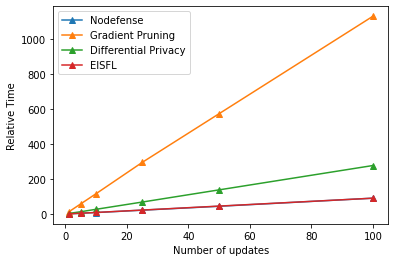

In [4]:
import matplotlib.pyplot as plt
N_UPDATES = [1, 5, 10, 25, 50, 100]
with open('latency_n_update.pkl', 'rb') as f:
    result = pickle.load(f)
nodef_lst = result['Nodefense']
gp_lst    = result['Gradient Pruning']
dp_lst    = result['Differential Privacy']
eisfl_lst = result['EISFL']
nodef_lst = np.mean(nodef_lst, axis=1)
gp_lst    = np.mean(gp_lst, axis=1)
dp_lst    = np.mean(dp_lst, axis=1)
eisfl_lst = np.mean(eisfl_lst, axis=1)

plt.plot(N_UPDATES, np.array(nodef_lst)/nodef_lst[0], '^-', label='Nodefense')
plt.plot(N_UPDATES, np.array(gp_lst)/nodef_lst[0]   , '^-', label='Gradient Pruning')
plt.plot(N_UPDATES, np.array(dp_lst)/nodef_lst[0]   , '^-', label='Differential Privacy')
plt.plot(N_UPDATES, np.array(eisfl_lst)/nodef_lst[0], '^-', label='EISFL')
plt.xlabel('Number of updates')
plt.ylabel('Relative Time')
plt.legend()
plt.show()

In [147]:
N_UPDATES = 1
ITER = 20
n_layers = list(range(1, 11))
nodef_lst = []
gp_lst = []
dp_lst = []
eisfl_lst = []  
for n in n_layers:
    model = MLP(n_layer=n)
    print('Number of layers:', n)
    elapsed_times, peak_mems = nodefense(model, iteration=ITER, num_batch=N_UPDATES)
    nodef_lst.append(elapsed_times)
    print('Nodefense: {:.3f}ms'.format(sum(elapsed_times)/len(elapsed_times)*1000))
    # print('Peak memory usage: {:.3f}MB'.format(sum(peak_mems)/len(peak_mems)/1024/1024))
    elapsed_times, peak_mems = gp(model, iteration=ITER, num_batch=N_UPDATES)
    gp_lst.append(elapsed_times)
    print('Gradient Pruning: {:.3f}ms'.format(sum(elapsed_times)/len(elapsed_times)*1000))
    # print('Peak memory usage: {:.3f}MB'.format(sum(peak_mems)/len(peak_mems)/1024/1024))
    elapsed_times, peak_mems = dp(model, iteration=ITER, num_batch=N_UPDATES)
    dp_lst.append(elapsed_times)
    print('Differential Privacy: {:.3f}ms'.format(sum(elapsed_times)/len(elapsed_times)*1000))
    elapsed_times, peak_mems = eisfl(model, iteration=ITER, num_batch=N_UPDATES)
    eisfl_lst.append(elapsed_times)
    print('EISFL: {:.3f}ms'.format(sum(elapsed_times)/len(elapsed_times)*1000))
    print("#"*50)

result = {'Nodefense': nodef_lst, 'Gradient Pruning': gp_lst, 'Differential Privacy': dp_lst, 'EISFL': eisfl_lst}
with open('latency_depth.pkl', 'wb') as f:
    pickle.dump(result, f)

Number of layers: 1
Nodefense: 38.387ms
Gradient Pruning: 403.924ms
Differential Privacy: 107.996ms
EISFL: 48.069ms
##################################################
Number of layers: 2
Nodefense: 42.834ms
Gradient Pruning: 533.716ms
Differential Privacy: 139.900ms
EISFL: 52.036ms
##################################################
Number of layers: 3
Nodefense: 48.048ms
Gradient Pruning: 616.048ms
Differential Privacy: 135.996ms
EISFL: 63.990ms
##################################################
Number of layers: 4
Nodefense: 58.527ms
Gradient Pruning: 717.467ms
Differential Privacy: 159.992ms
EISFL: 76.071ms
##################################################
Number of layers: 5
Nodefense: 67.537ms
Gradient Pruning: 811.294ms
Differential Privacy: 195.814ms
EISFL: 84.089ms
##################################################
Number of layers: 6
Nodefense: 73.874ms
Gradient Pruning: 882.316ms
Differential Privacy: 207.909ms
EISFL: 99.987ms
#################################################

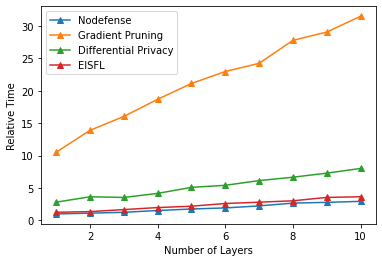

In [148]:
with open('latency_depth.pkl', 'rb') as f:
    result = pickle.load(f)
nodef_lst = result['Nodefense']
gp_lst    = result['Gradient Pruning']
dp_lst    = result['Differential Privacy']
eisfl_lst = result['EISFL']
nodef_lst = np.mean(nodef_lst, axis=1)
gp_lst    = np.mean(gp_lst, axis=1)
dp_lst    = np.mean(dp_lst, axis=1)
eisfl_lst = np.mean(eisfl_lst, axis=1)

plt.plot(n_layers, np.array(nodef_lst)/nodef_lst[0], '^-', label='Nodefense')
plt.plot(n_layers, np.array(gp_lst)/nodef_lst[0]   , '^-', label='Gradient Pruning')
plt.plot(n_layers, np.array(dp_lst)/nodef_lst[0]   , '^-', label='Differential Privacy')
plt.plot(n_layers, np.array(eisfl_lst)/nodef_lst[0], '^-', label='EISFL')
plt.xlabel('Number of Layers')
plt.ylabel('Relative Time')
plt.legend()
plt.show()

In [1]:
import DataManager as dm

train, _ = dm.MITBIH()

5618 42620 5328 17023 4496 370
1405 10655 1332 4256 1124 92
torch.Size([58062, 30, 60]) torch.Size([58062])


In [8]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
transform  = transforms.Compose([transforms.ToTensor()])
testset  = datasets.STL10(root='../../../disk1/Kichang/dataset', split='test'  , download=False, transform=transform)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


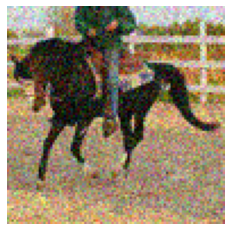

In [31]:
import torch
import matplotlib.pyplot as plt
img, _ = testset[0]

plt.imshow((img*0.9 + torch.randn_like(img)*0.1).numpy().transpose(1,2,0))
plt.axis('off')
plt.show()

In [45]:
import models

model = models.vit()
optimizer = torch.optim.Adam(model.parameters(), lr=1)
gt_img, gt_label = testset[0]
gt_img = gt_img[None,]

model.train()
o = model(gt_img)
loss = torch.nn.CrossEntropyLoss()(o, torch.LongTensor([gt_label]))
loss.backward()
optimizer.step()

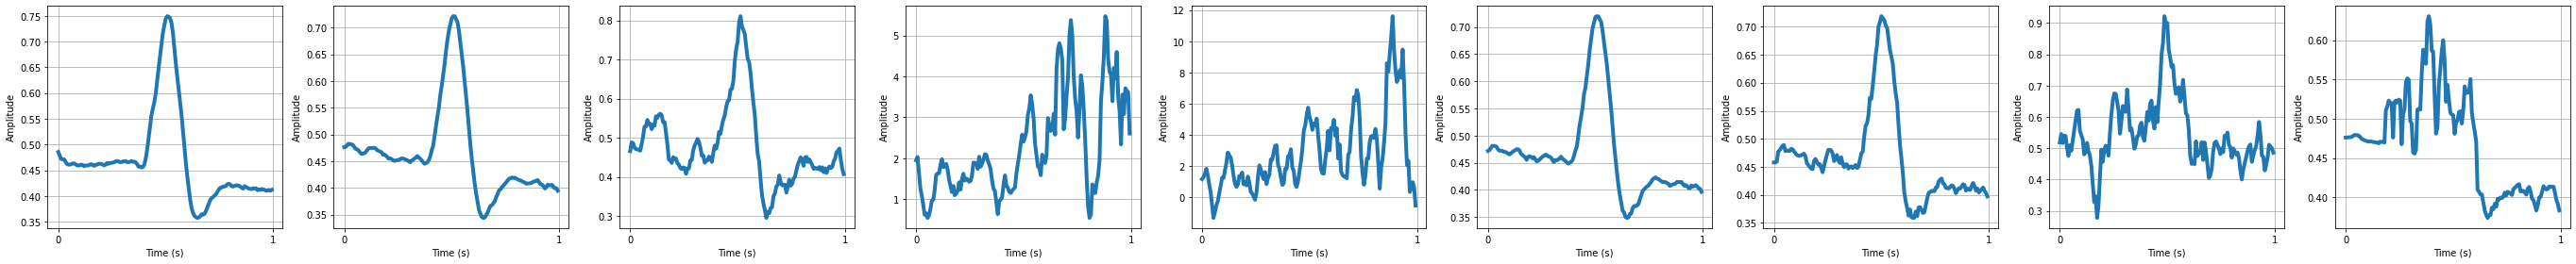

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

plt.figure(figsize=(38,4))
plt.subplot(1,9,1)
x = np.load('./results/NoDefense/IG_MITBIH/2.npy')
plt.plot(x.reshape(-1)[-150:], linewidth=4)
plt.xticks([0,150], [0, 1])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()

x = np.load('./results/NoDefense/IG_MITBIH/2_result.npy')
plt.subplot(1,9,2)
plt.plot(uniform_filter1d(x.reshape(-1)[-150:], size=5), linewidth=4)
plt.xticks([0,150], [0, 1])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.subplot(1,9,3)
x = np.load('./results/GradPrune_0.7/IG_MITBIH_GradPrune_0.7/2_result.npy')
plt.plot(uniform_filter1d(x.reshape(-1)[-150:], size=5), linewidth=4)
plt.xticks([0,150], [0, 1])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.subplot(1,9,4)
x = np.load('./results/GradPrune_0.9/IG_MITBIH_GradPrune_0.9/2_result.npy')
plt.plot(uniform_filter1d(x.reshape(-1)[-150:], size=5), linewidth=4)
plt.xticks([0,150], [0, 1])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.subplot(1,9,5)
x = np.load('./results/GradPrune_0.99/IG_MITBIH_GradPrune_0.99/2_result.npy')
plt.plot(uniform_filter1d(x.reshape(-1)[-150:], size=5), linewidth=4)
plt.xticks([0,150], [0, 1])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.subplot(1,9,6)
x = np.load('./results/DP/IG_MITBIH_8.0_1e-05/2_result.npy')
plt.plot(uniform_filter1d(x.reshape(-1)[-150:], size=5), linewidth=4)
plt.xticks([0,150], [0, 1])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.subplot(1,9,7)
x = np.load('./results/DP/IG_MITBIH_2.0_1e-05/2_result.npy')
plt.plot(uniform_filter1d(x.reshape(-1)[-150:], size=5), linewidth=4)
plt.xticks([0,150], [0, 1])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.subplot(1,9,8)
x = np.load('./results/DP/IG_MITBIH_0.5_1e-05/2_result.npy')
plt.plot(uniform_filter1d(x.reshape(-1)[-150:], size=5), linewidth=4)
plt.xticks([0,150], [0, 1])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.subplot(1,9,9)
x = np.load('./results/EISFL/IG_MITBIH/2_result.npy')
plt.plot(uniform_filter1d(x.reshape(-1)[-150:], size=5), linewidth=4)
plt.xticks([0,150], [0, 1])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.tight_layout()
plt.show()

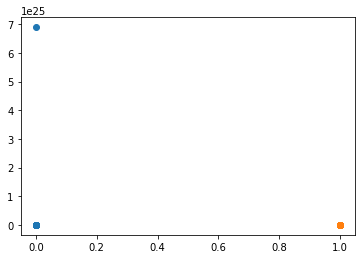

In [94]:
import pickle

with open('./results/NoDefense/IG_MITBIH/result.pickle', 'rb') as f:
    result = pickle.load(f)

plt.scatter(0*np.ones(len(result['mse'])), result['mse'])
plt.scatter(1*np.ones(len(result['psnr'])), result['psnr'])
plt.show()


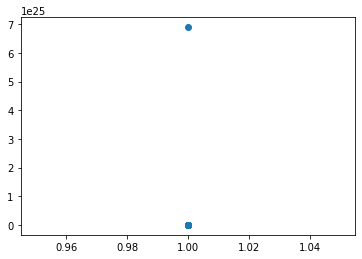

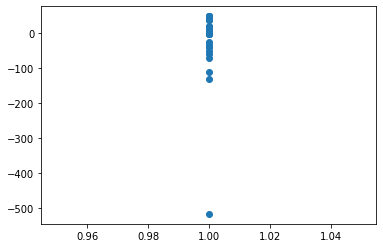

In [97]:
plt.scatter(1*np.ones(len(result['mse'])), result['mse'])
plt.show()
plt.scatter(1*np.ones(len(result['psnr'])), result['psnr'])
plt.show()